In [1]:
import pandas as pd
import numpy as np
import yaml
import pycountry
import pycountry_convert as pc
from datetime import datetime
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
# CZE, FRA, GRC

In [3]:
data_swissre = pd.read_csv('./data/economic_weighted.csv', parse_dates=['date']).set_index('date')

iso_codes = ['AUT','BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'GBR', 'CHE', 'NOR']

data_swissre = data_swissre[data_swissre['iso_code'].isin(iso_codes)]

/Users/francescoposa/opt/anaconda3/envs/personal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# data_swissre[(data_swissre['iso_code'] == 'CHE') & (data_swissre.index >= '2021-04-11')]

In [5]:
for iso_code in iso_codes:
    a = pycountry.countries.get(alpha_3=iso_code)
    print(pc.country_alpha2_to_country_name(a.alpha_2))

Austria
Belgium
Bulgaria
Croatia
Cyprus
Czechia
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Netherlands
Poland
Portugal
Romania
Slovakia
Slovenia
Spain
Sweden
United Kingdom
Switzerland
Norway


# Selecting columns for the first model

In [6]:
with open('config/economic_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [7]:
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['economic'] +\
            swissre_features['policies']+\
            swissre_features['outcome']
            #swissre_features['vaccines'] +\

rep_rate = 'epiforecasts_effective_reproduction_number_median'

In [8]:
df = data_swissre[columns_to_use].copy()
df.columns

Index(['name', 'iso_code', 'cases', 'weight',
       'epiforecasts_effective_reproduction_number_median',
       'total_population_all', 'total_population_below_1',
       'total_population_1_to_4', 'total_population_5_to_14',
       'total_population_15_to_24', 'total_population_25_to_34',
       'total_population_35_to_54', 'total_population_55_to_74',
       'total_population_above_75', 'population_percentage_over_60',
       'hospital_beds_per_1000', 'physicians_per_1000', 'nurses_per_1000',
       'maxtempC', 'mintempC', 'tempC', 'FeelsLikeC', 'humidity', 'pressure',
       'HeatIndexC', 'uvIndex', 'totalSnow_cm', 'sunHour', 'windspeedKmph',
       'precipMM', 'unemployment_rate_2021_09_30',
       'unemployment_rate_2021_12_31', 'unemployment_rate_2019_03_31',
       'unemployment_rate_2019_06_30', 'unemployment_rate_2019_09_30',
       'unemployment_rate_2019_12_31', 'gdp_2019_03_31', 'gdp_2019_06_30',
       'gdp_2019_09_30', 'gdp_2019_12_31', 'gdp_2020_03_31', 'gdp_2020_06_30'

In [9]:
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df = df[df.index >= '2020-04-01'].sort_index() #

In [10]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [11]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 30


In [12]:
# Putting NaN where the estimated reproduction number is larger than 4
df[rep_rate] = np.where(df[rep_rate] >= 4, np.nan, df[rep_rate])

In [13]:
# Shifting the reproduction rate by 11 days for each country
df['date_index'] = df.index
df = df.sort_values(by = ['iso_code', 'date_index'])
df['shifted_r_estim'] = df[rep_rate]

In [14]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 30


In [15]:
df.loc[df['iso_code'] == 'CYP', 'population_percentage_over_60'] = 19.79

In [16]:
df.to_csv('economic_data_with_excluded_countries_to_avoid_code_in_backend.csv')

# Training the first model

In [18]:
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot
import matplotlib.patches as mpatches

In [19]:
selected_countries = ['LTU', 'SVK', 'MLT', 'AUT', 'HUN', 'LUX', 'LVA', 'HRV', 'ROU', 'CHE', 'IRL', 'EST',
 'FIN', 'CYP', 'SVN', 'DNK', 'ITA', 'ESP', 'BGR', 'DEU', 'FRA', 'GBR', 'NOR', 'GRC',
 'NLD', 'BEL', 'PRT', 'SWE']

In [20]:
len(selected_countries)

28

In [21]:
start_time = time.time()

for iso_code in selected_countries:
    print(f"Predicting {iso_code}...")
    
    train_cols= swissre_features['demography'] +\
                    swissre_features['sanitary'] +\
                    swissre_features['economic'] +\
                    swissre_features['policies'] #+ ['shifted_r_estim']

    final_train_cols = [col for col in train_cols if not df[df['iso_code'] ==  iso_code][col].isnull().all()]
    final_train_cols = [col for col in final_train_cols if not df[df['iso_code'] != iso_code][col].std() == 0]
    
    if(set(train_cols) != set(final_train_cols)):
        print("Final train cols diverse!")
        print(set(train_cols) - set(final_train_cols))
    
    context = Context()

    pipeline = Pipeline(df, final_train_cols, 'unemployment_rate_idx', iso_code, 28, context, 'weight') #shifted_r_estim
    pipeline.fit_pipeline(save_model=True)
    
delta = time.time() - start_time
print(f"--- {delta} seconds ---")

computation_cost = delta * (40 / 3.6e6) * 447 

print(f"--- {computation_cost} gCO2eq ---")

Global seed set to 42
Global seed set to 42


Predicting LTU...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machin

..............................................................................

Global seed set to 42
Global seed set to 42


.Predicting SVK...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...............................

Global seed set to 42
Global seed set to 42


.Predicting MLT...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...........................................................

Global seed set to 42
Global seed set to 42


.Predicting AUT...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Predicting HUN...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Predicting LUX...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..................................

Global seed set to 42
Global seed set to 42


.Predicting LVA...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Predicting HRV...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Predicting ROU...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


.....................................

Global seed set to 42
Global seed set to 42


.Predicting CHE...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Predicting IRL...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


.....................................

Global seed set to 42
Global seed set to 42


.Predicting EST...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...................................................................

Global seed set to 42
Global seed set to 42


.Predicting FIN...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Predicting CYP...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...................................................................................................................

Global seed set to 42
Global seed set to 42


.Predicting SVN...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Predicting DNK...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


............................................

Global seed set to 42
Global seed set to 42


.Predicting ITA...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Predicting ESP...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...............................................

Global seed set to 42
Global seed set to 42


.Predicting BGR...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Predicting DEU...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Predicting FRA...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Predicting GBR...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Predicting NOR...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


................................

Global seed set to 42
Global seed set to 42


.Predicting GRC...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...............................................................................

Global seed set to 42
Global seed set to 42


.Predicting NLD...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...........................................................................

Global seed set to 42
Global seed set to 42


.Predicting BEL...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Predicting PRT...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Predicting SWE...
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.5 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


............................--- 2184.63099694252 seconds ---
--- 10.850333951481185 gCO2eq ---


In [22]:
df2['pred']

date
2020-05-01    1.205482
2020-06-01    1.194255
2020-07-01    1.271732
2020-08-01    1.257575
2020-09-01    1.206289
2020-10-01    1.289789
2020-11-01    1.179801
2020-12-01    1.292545
2021-01-01    1.371004
2021-02-01    1.369736
2021-03-01    1.391132
2021-04-01    1.389417
2021-05-01    1.256396
Name: pred, dtype: float64

In [19]:
predictions

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 1.20634027, 1.20716935, 1.20649863,
       1.2054816 , 1.20466142, 1.20401787, 1.20352365, 1.20315319,
       1.20287978, 1.20268274, 1.20254515, 1.20245348, 1.20239709,
       1.22230317, 1.21524006, 1.20853346, 1.20461295, 1.2065241 ,
       1.21144627, 1.21580526, 1.21789463, 1.21808255, 1.21689425,
       1.21533993, 1.21421449, 1.2132714 , 1.21046665, 1.20907651,
       1.2082049 , 1.20829354, 1.20904276, 1.21044983, 1.19633136,
       1.19370622, 1.19425463, 1.19677891, 1.19920244, 1.20044501,
       1.17370642, 1.14048535, 1.10301032, 1.11367541, 1.1247679 ,
       1.13433478, 1.14180226, 1.13534364, 1.12821541, 1.12279

In [20]:
ground

date
2020-04-01    0.606264
2020-04-02    0.622527
2020-04-03    0.638791
2020-04-04    0.655055
2020-04-05    0.671319
                ...   
2021-05-27    1.706044
2021-05-28    1.704396
2021-05-29    1.702747
2021-05-30    1.701099
2021-05-31    1.699451
Name: unemployment_rate_idx, Length: 426, dtype: float64

## More countries

In [18]:
selected_names = ['Switzerland'] #, 'Denmark', 'France'
countries = ['CHE'] # , 'DNK', 'FRA'

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machin

...........................

TypeError: 'AxesSubplot' object is not subscriptable

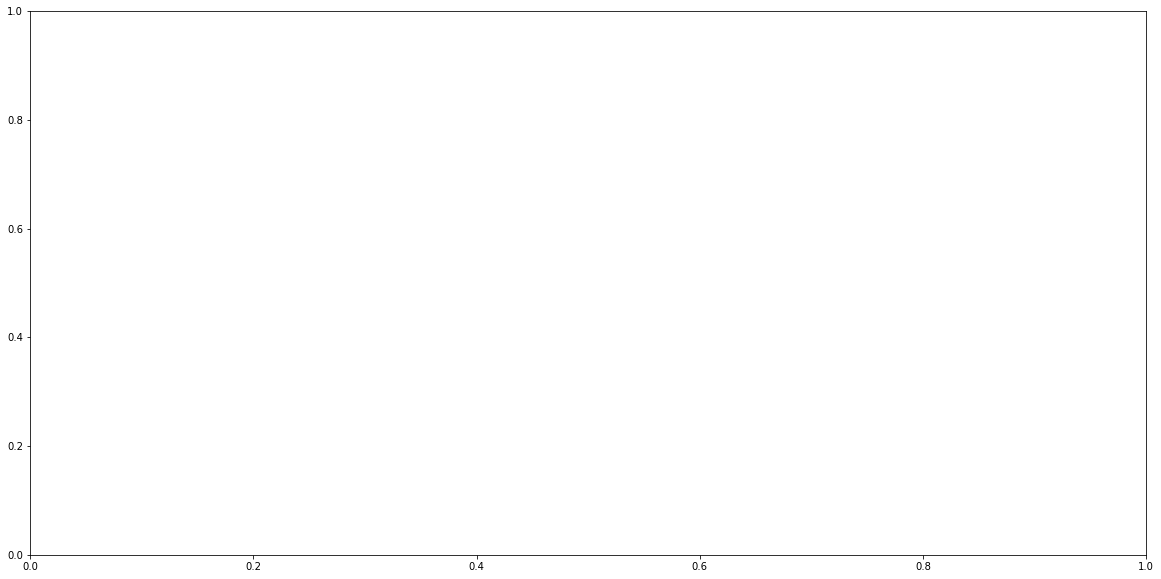

In [19]:
fig, axis = plt.subplots(len(countries), 1, sharex=True, sharey=True, figsize = (20, 10))

for indice in range(len(countries)):   
    # Final training colums
    train_cols= swissre_features['demography'] +\
                swissre_features['sanitary'] +\
                # swissre_features['vaccines']+\
                swissre_features['economic'] +\
                swissre_features['policies']+ ['shifted_r_estim']# +\
              #  swissre_features['weather']

    final_train_cols = [col for col in train_cols if not df[df['iso_code'] == countries[indice]][col].isnull().all()]
    final_train_cols = [col for col in final_train_cols if not df[df['iso_code'] != countries[indice]][col].std() == 0]
    
    context = Context()
    
    pipeline = Pipeline(df, final_train_cols, 'unemployment_rate_idx', countries[indice], 28, context, 'weight') #shifted_r_estim
    pipeline.fit_pipeline(save_model=False)
    
    predictions = pipeline.predict()
    
    test_indices = df['iso_code'] == countries[indice]
    index = df.loc[test_indices].index
    ground = df.loc[test_indices]['unemployment_rate_idx']
    error_curve = np.abs(ground - predictions)

    df2 = pd.DataFrame({'index': index, 'ground': ground, 'pred': predictions, 'error': error_curve}).sort_values(by = 'index')
    df2 = df2[(df2['index'] >= '2020-05-01') & (df2['index'].dt.day == 1)]

    df2['index'] = df2['index'].dt.strftime('%Y-%m')

    df2.plot.bar(x = 'index', y = ['ground', 'pred'], rot = 0, fontsize=14, legend=False, ax = axis[indice])

    pre_patch = mpatches.Patch(color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), label='Predicted UER')
    ground_patch = mpatches.Patch(color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), label='Reported (and interpolated) UER')
    axis[0].legend(handles=[ground_patch, pre_patch], fontsize=14)

    axis[indice].set_title(f"{selected_names[indice]} ({countries[indice]})", fontsize=16)
    axis[indice].set_xlabel("Date", fontsize=16);
    axis[indice].set_ylabel("UER", fontsize=16);

In [21]:
fig.savefig('EconomicPlots.pdf', bbox_inches='tight')

In [18]:
test_indices = df['iso_code'] == final_iso_code
index = df.loc[test_indices].index
ground = df.loc[test_indices]['unemployment_rate_idx']
error_curve = np.abs(ground - predictions)

df2 = pd.DataFrame({'index': index, 'ground': ground, 'pred': predictions, 'error': error_curve}).sort_values(by = 'index')
df2 = df2[(df2['index'] >= '2020-05-01') & (df2['index'].dt.day == 1)]

df2['index'] = df2['index'].dt.date


df2.plot.bar(x = 'index', y = ['ground', 'pred'], rot = 0, figsize=(20,5), fontsize=14, legend=False)

pre_patch = mpatches.Patch(color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), label='Predicted')
ground_patch = mpatches.Patch(color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), label='Ground')
plt.legend(handles=[ground_patch, pre_patch], fontsize=16)

plt.title("Economic predictions for CHE", fontsize=18)
plt.xlabel("Date", fontsize=18);
plt.savefig('EconomicCHE.pdf', bbox_inches='tight')

NameError: name 'final_iso_code' is not defined

## Predictions for each country

In [19]:
index = []
ground = []
error_curve = []
country = []
predictions_list = []

for final_iso_code in iso_codes:
    # Final training colums
    train_cols= swissre_features['demography'] +\
                swissre_features['sanitary'] +\
                swissre_features['vaccines']['to_use'] +\
                swissre_features['economic']['to_use'] +\
                swissre_features['policies']['to_use'] + ['shifted_r_estim'] #swissre_features['weather'] +\

    final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]
    final_train_cols = [col for col in final_train_cols if not df[col].std() == 0]
    context = Context()
    pipeline = Pipeline(df, final_train_cols, 'unemployment_rate_idx', final_iso_code, 28, context, 'weight') #shifted_r_estim
    try:
        pipeline.fit_pipeline(save_model=False)
        predictions = pipeline.predict()
        test_indices = df['iso_code'] == final_iso_code
        index_iso = df.loc[test_indices].index
        ground_iso = df.loc[test_indices]['unemployment_rate_idx']
        error_curve_iso = np.abs(ground_iso - predictions)
        country_iso = [final_iso_code for i in index_iso]
        index.extend(index_iso)
        ground.extend(ground_iso)
        error_curve.extend(error_curve_iso)
        country.extend(country_iso)
        predictions_list.extend(predictions)
    except:
        print(f"NOT ENOUGH DATA FOR COUNTRY {final_iso_code}")
    

result_df = pd.DataFrame({'iso_code': country, 'index': index, 'ground': ground, 'pred': predictions_list, 'error': error_curve}).sort_values(by = 'index')
result_df = result_df[(result_df['index'] >= '2020-05-01') & (result_df['index'].dt.day == 1)]
result_df['index'] = result_df['index'].dt.date
result_df

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


......................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.8 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...............................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


................................................................................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


......................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
Global seed set to 42
Global seed set to 42


NOT ENOUGH DATA FOR COUNTRY MLT
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.....................................................................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..................................................................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


......................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

,iso_code,index,ground,pred,error
4662,GBR,2020-05-01,1.797143,1.182496,0.614646
3118,ESP,2020-05-01,5.930440,1.829132,4.101308
10066,SVK,2020-05-01,1.760549,5.946790,4.186241
30,AUT,2020-05-01,0.835934,1.512610,0.676676
6592,ITA,2020-05-01,0.906044,3.518695,2.612651
...,...,...,...,...,...
1523,CHE,2021-04-01,1.798352,1.803374,0.005022
365,AUT,2021-04-01,1.737912,1.258592,0.479320
2681,DEU,2021-04-01,1.288791,2.082680,0.793889
6155,HUN,2021-04-01,1.744286,0.000000,1.744286


In [31]:
result_df.rename(columns={"index": "date"}).to_csv("./data/Economic_data/economic_predictions.csv", index=False)